In [3]:
from resources import *
%matplotlib inline

## The Lorenz (1963) system

The Lorenz-63 system is described by the 3 coupled of differential equations (ODE):

$$
\begin{aligned}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{aligned}
$$

[Further description](DA_intro.pdf#page=22). As a test case for DA, the state vector is $\mathbf{x} = (x,y,z)$, and the parameters are typically set to

In [4]:
SIGMA = 10.0
BETA  = 8/3
RHO   = 28.0

The dynamics can be written as follows

In [5]:
def dxdt(x_y_z, t0, sigma=SIGMA, beta=BETA, rho=RHO):
    """Compute the time-derivative of the Lorenz-63 system."""
    x, y, z = x_y_z
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

### Computing trajectories

Below is a function that can integrate the differential equations numerically and then plot the solutions. This function has arguments that control the parameters of the differential equation ($\sigma$, $\beta$, $\rho$) and of the numerical integration (`N`, `T`).

In [6]:
from scipy.integrate import odeint # numerical integrator

def animate_lorenz(output=[],sigma=SIGMA, beta=BETA, rho=RHO, N=2, eps=0.01, T=1.0):    
    
    # Initial conditions: perturbations around some "proto" state
    seed(1)
    x0_proto = array([-6.1, 1.2, 32.5])
    x0 = x0_proto + eps*randn((N, 3))

    # Compute trajectories
    tt = linspace(0, T, int(100*T)+1)               # Time instances for trajectory
    d2 = lambda x,t: dxdt(x,t, sigma,beta,rho)      # Define dxdt(x,t) with fixed params.
    xx = array([odeint(d2, x0i, tt) for x0i in x0]) # Integrate
    
    
    # PLOTTING
    ax = plt.figure(figsize=(7,4)).add_subplot(111, projection='3d')
    
    colors = plt.cm.jet(linspace(0,1,N))
    for i in range(N):
        ax.plot(*(xx[i,:,:].T),'-'  ,c=colors[i])
        #ax.scatter3D(*xx[i,0 ,:],s=20,c=colors[i],marker='<')
        ax.scatter3D(*xx[i,-1,:],s=40,c=colors[i])

    ax.set_xlim((-15, 15))
    ax.set_ylim((-25, 25))
    ax.set_zlim((15, 40))
    ax.view_init(30, 120)
    ax.axis('off')
    plt.show()
    
    output.insert(0,xx)

We now provide the animation function with GUI sliders.

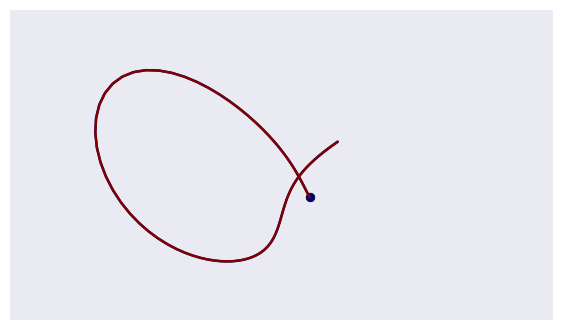

In [7]:
from IPython.display import display
output = []
w = interactive(animate_lorenz, output=fixed(output),
                sigma=(0.,50), rho=(0.,50), beta=(0.,5),
                N=(0,50), eps=(0.01,4),T=(0.1,30))
HBox([ VBox(w.children[:3]), VBox(w.children[3:]) ])

**Exc**: Move `T` (use your arrow keys). What does it signify? What are `N`, `eps` for?

**Exc**: investigate sensititivy to initial conditions by
 * sliding `eps`
 * sliding `T`

What does this mean for predictability? I.e. how far into the future do you reckon one could produce forecasts with this system?

Chaos is also known as the butterfly effect; "A buttefly that flaps its wings in Brazil can "cause" a hurricane in Texas". As opposed to the opinions of Descartes/Newton/Laplace, chaos effectively means that even in a deterministic (non-stochastic) universe, we can only predict "so far" into the future. Is it a coincidence that the shape of the trajectories also look like a butterfly?

### Averages
The code below computes the average location of the $i$-th component.

In [ ]:
xx = output[0]
ensemble_average = xx.mean(axis=0)
time_average     = xx.mean(axis=1)

In [ ]:
i = 1             # state component index
n = 0             # ensemble member index
K = xx.shape[1]-1 # time index
plt.hist(xx[:,K,i]        ,normed=1,label="ensemble distribution",alpha=1.0)
plt.hist(xx[n,:,i]        ,normed=1,label="temporal distribution",alpha=0.5)
#plt.hist(xx[:,:,i].ravel(),normed=1,label="total    distribution",alpha=0.5)
plt.legend();

**Exc:** Do you think the histograms actually approximate the same distribution (for large $N$ and $T$)? So then, if testing average performance with the Lorenz-63 model, should you run several short or one long experiment?

## The "Lorenz-95" model
[Further description](DA_intro.pdf#page=23).

The model is animated below.

In [ ]:
# For all i, any n: s(x,n) := x[i+n], circularly.
def s(x,n):
    return np.roll(x,-n)

def animate_lorenz_95(m=40,Force=8.0,eps=0.01,T=0):
    # Initial conditions: perturbations
    x0 = zeros(m)
    x0[0] = eps
    
    def dxdt(x,t):
        return (s(x,1)-s(x,-2))*s(x,-1) - x + Force
    
    tt = linspace(0, T, int(40*T)+1)
    xx = odeint(lambda x,t: dxdt(x,t), x0, tt)
    
    plt.figure(figsize=(7,4))
    
    # Plot last only
    #plt.plot(xx[-1],'b')

    # Plot multiple
    Lag = 8
    colors = sns.cubehelix_palette(Lag)
    for k in range(Lag,0,-1):
        plt.plot(xx[max(0,len(xx)-k)],c=colors[Lag-k])

    plt.ylim(-10,20)
    plt.show()
    
interact(animate_lorenz_95,eps=(0.01,1,0.1),T=(0.05,20,0.05),Force=(0,40,1));

**Exc:** What's the doubling time of the system?

**Exc:** Under which settings of the force `F` is the system chaotic?

Prediction (forecasting) with these systems are challenging because they are chaotic: small errors grow exponentially. It is therefore paramount to minimize the intial error as much as possible. This is a task for DA.

**Exc:** Suppose $x(t)$ and $z(t)$ are twins: they evolve according to the same law $f$:

$$\frac{dx}{dt} = f(x) \\ \frac{dz}{dt} = f(z) \, ,$$ for some $f$.

Suppose $z(0)$ is close to $x(0)$, and define the "error": $\varepsilon(t) = x(t) - z(t)$.
* a) Show that the error evolves according to the differential equation $\frac{d \varepsilon}{dt} \approx F \varepsilon$, where $F = \frac{df}{dx}(x(t))$.
* b) Show that $\varepsilon(t) = \varepsilon(0) e^{F t} $, i.e. that the error grows exponentially.
* c)
 * 1) Suppose $F<1$. What happens to the error?
 * 2) Now suppose $F>1$. Given that all observations are uncertain (i.e. $R_t>0$, if only ever so slightly), can we ever hope to estimate $x(t)$ with 0 uncertainty?

Now suppose $z(t)$ evolves according to $\frac{dz}{dt} = g(z)$, with $g \neq f$.
* d) What is now the differential equation governing the evolution of the error $\varepsilon$?
* e) How might we model a saturation of the error at some level? Can you solve this equation?

In [8]:
show_answer("error evolution")

KeyError: 'error evolution'

### Next: [Ensemble [Monte-Carlo] approach](T5 - Ensemble [Monte-Carlo] approach.ipynb)